In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn import metrics
import statsmodels.api as sm
import pylab as plt
from pandas.plotting import autocorrelation_plot

df = pd.read_csv('../data/PJME_hourly.csv',index_col='Datetime',parse_dates=True)
df.index = pd.DatetimeIndex(df.index).to_period('h')
df.sort_index(inplace=True)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00,30393.0
2002-01-01 02:00,29265.0
2002-01-01 03:00,28357.0
2002-01-01 04:00,27899.0
2002-01-01 05:00,28057.0


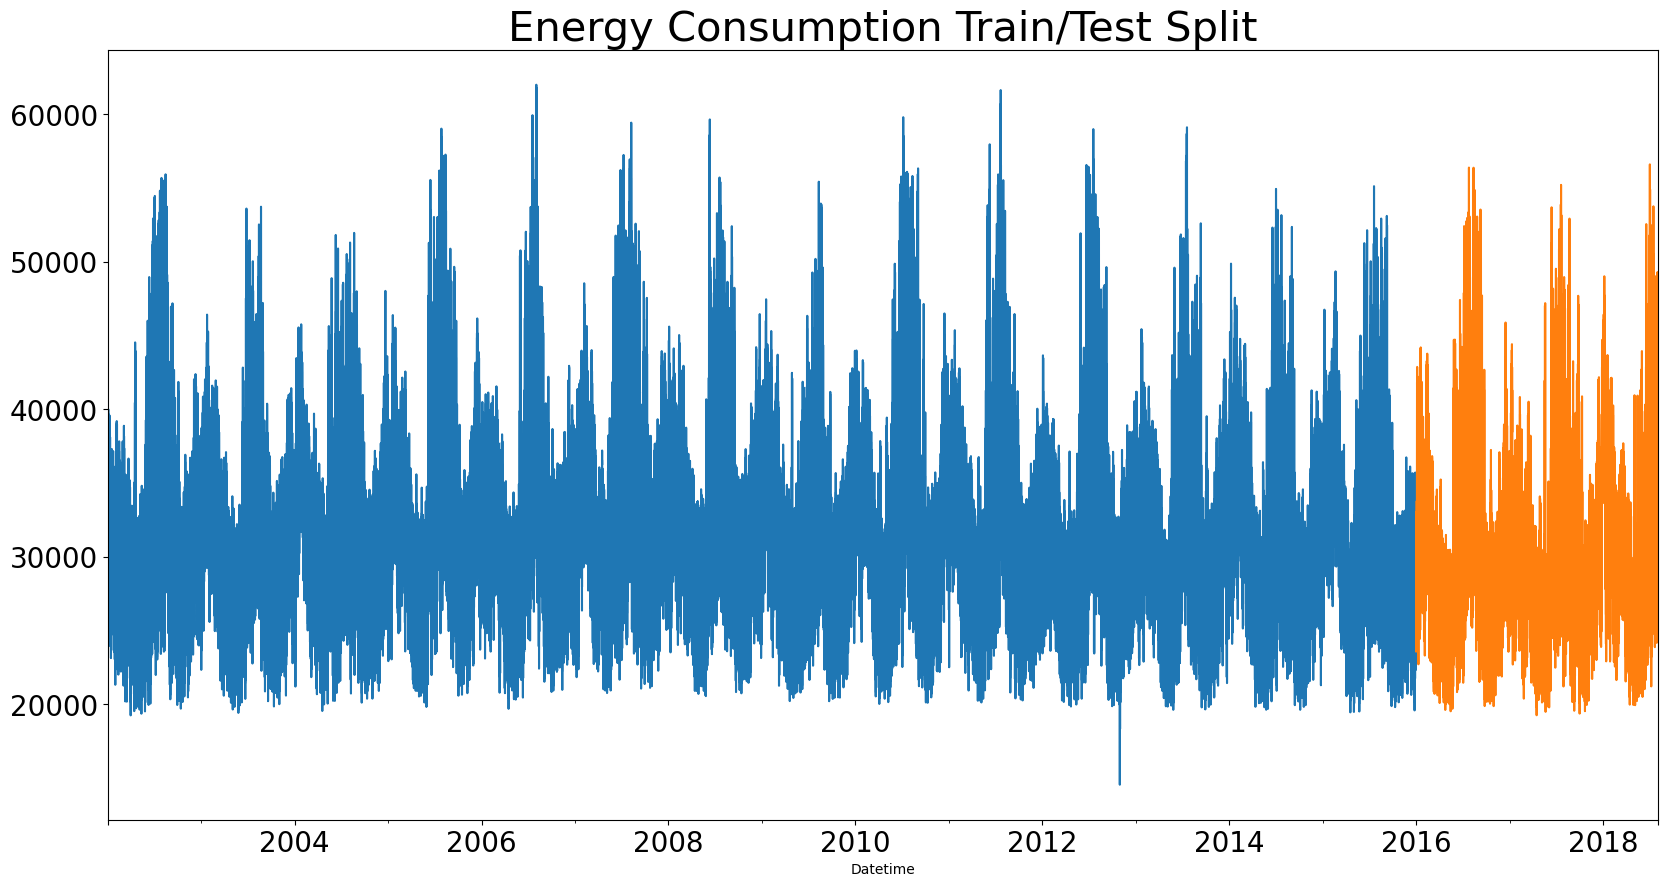

In [4]:
split_date = '2016-01-01'
train = df['PJME_MW'].loc[:split_date]
test = df['PJME_MW'].loc[split_date:]
train.plot(figsize=(20, 10), fontsize=20)
plt.title('Energy Consumption Train/Test Split', fontsize=30)
test.plot()
plt.show()

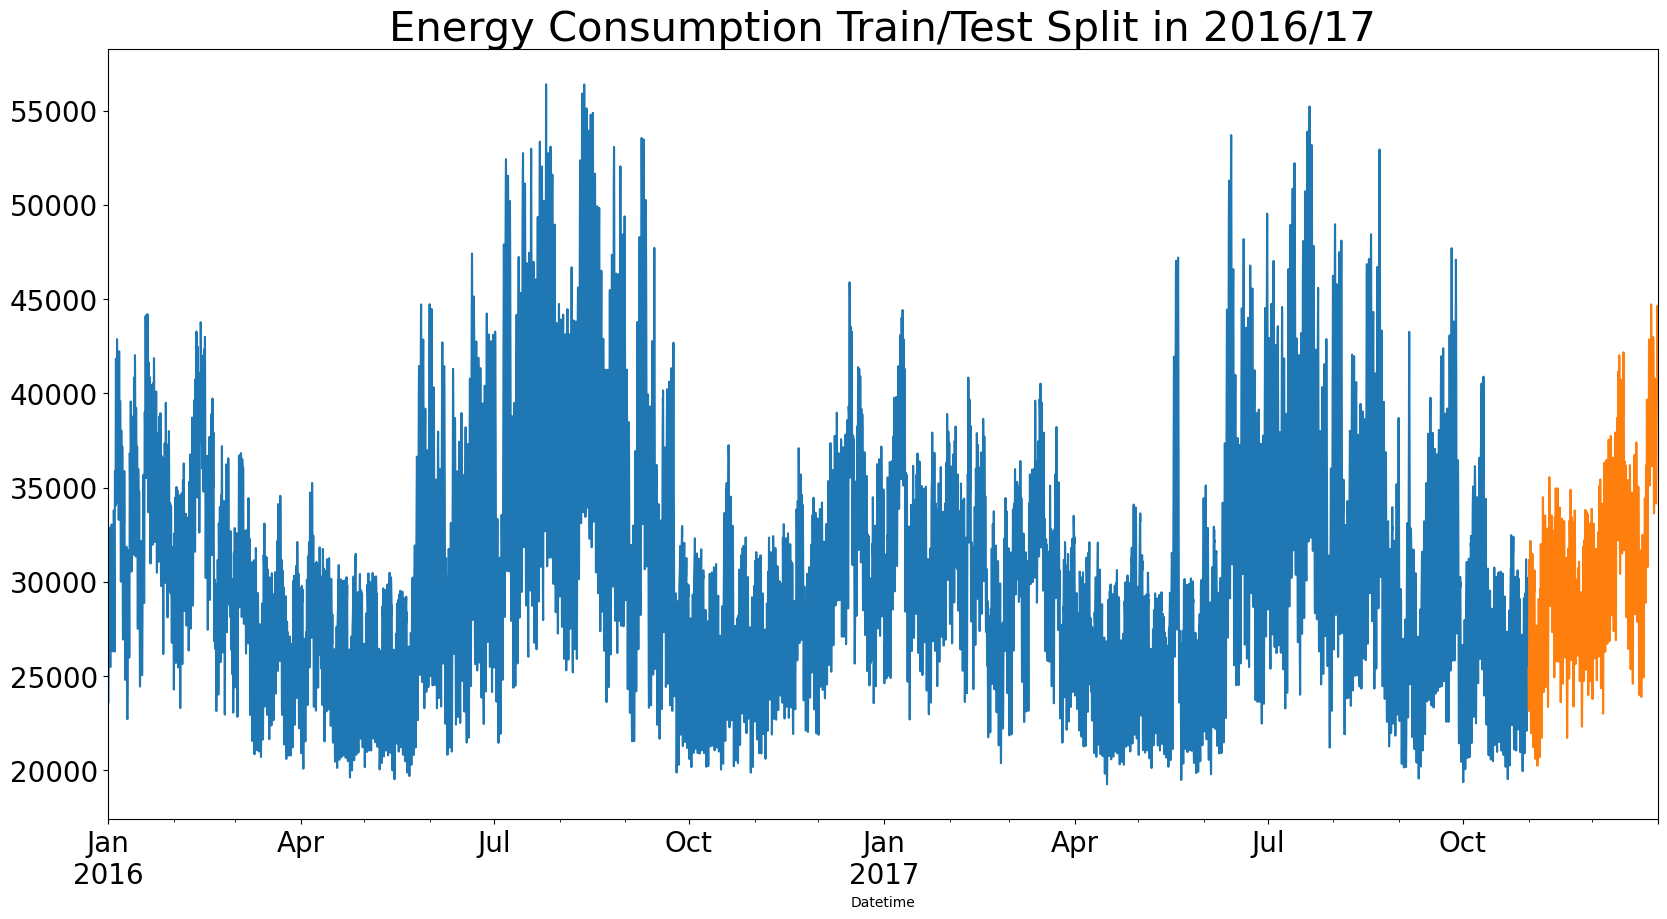

In [5]:
df2017 = df[(df.index.year == 2017) | (df.index.year == 2016)]
split_date = '2017-11-01'
train = df2017['PJME_MW'].loc[:split_date]
test = df2017['PJME_MW'].loc[split_date:]
train.plot(figsize=(20, 10), fontsize=20)
plt.title('Energy Consumption Train/Test Split in 2016/17', fontsize=30)
test.plot()
plt.show()

In [6]:
# model = sm.tsa.statespace.SARIMAX(endog = train, order = (1, 1, 1), seasonal_order = (1, 0, 1, 24))
model = sm.tsa.statespace.SARIMAX(endog = train, order = (2, 1, 2), seasonal_order = (1, 1, 1, 24))
model_res = model.fit(disp=0)
# warnings.filterwarnings("default")

model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              PJME_MW   No. Observations:                16103
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood             -113296.968
Date:                              Mon, 29 Apr 2024   AIC                         226607.937
Time:                                      10:24:59   BIC                         226661.733
Sample:                                  01-01-2016   HQIC                        226625.725
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2943      0.050      5.895      0.000       0.196       0.392
ar.L2          0.0586      0.031      1.913      0.056      -0.001       0.119
ma.L1          0.8281      0.050     16.580      0.000       0.730       0.926
ma.L2          0.2927      0.025     11.537      0.000       0.243       0.342
ar.S.L24       0.3309      0.007     46.842      0.000       0.317       0.345
ma.S.L24      -0.8464      0.004   -197.391      0.000      -0.855      -0.838
sigma2      7.651e+04    494.047    154.867      0.000    7.55e+04    7.75e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             16415.60
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Mean Squared Error: 13829739.792686738
Root Mean Squared Error: 3718.835811472017
Mean Absolute Error: 2762.2369221105655


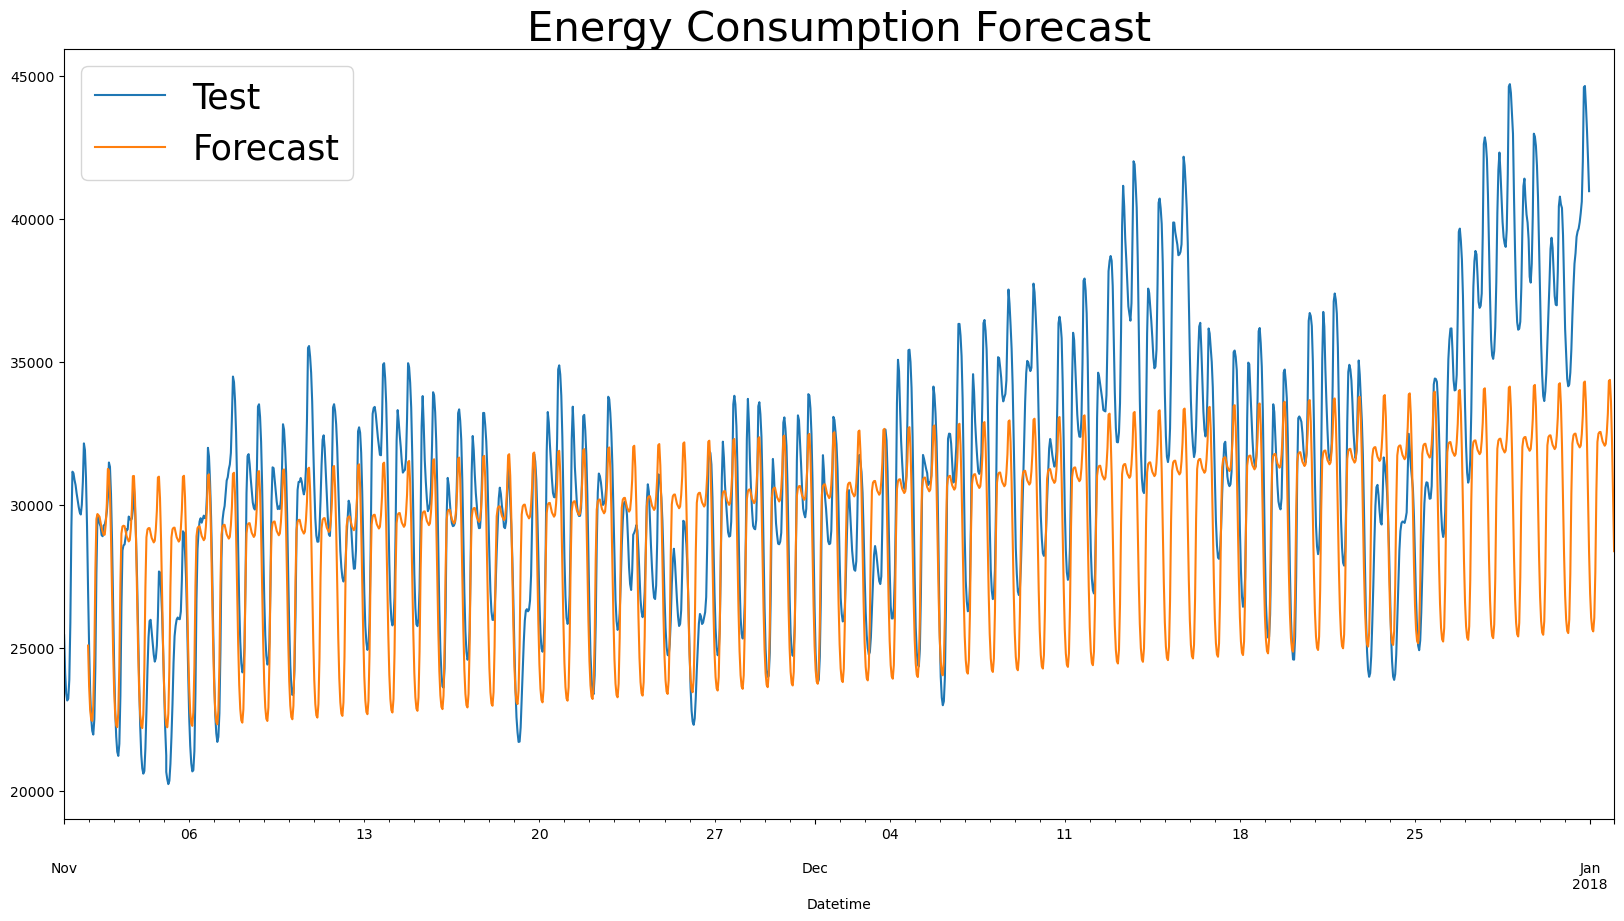

In [7]:
from sklearn import metrics

fcast_len = len(test)
fcast = model_res.forecast(fcast_len)
mse = metrics.mean_squared_error(test, fcast)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(test, fcast)
plt.figure(figsize=(20, 10))
plt.title('Energy Consumption Forecast', fontsize=30)
# train.plot(label='Train')
test.plot(label='Test')
fcast.plot(label='Forecast')

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
plt.legend(fontsize=25)
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['PJME_MW'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -19.881348
p-value: 0.000000


In [9]:
print(f'p-value: {result[1]}')

p-value: 0.0


In [ ]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
help(auto_arima)

In [ ]:
auto_arima(df['PJME_MW'])

In [ ]:
stepwise_fit = auto_arima(df['PJME_MW'], random_state=22, seasonal=True, D=24, trace=True)

stepwise_fit.summary()

In [ ]:
stepwise_fit = auto_arima(df['PJME_MW'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

## Split the data into train/test sets
The goal in this section is to:
* Split known data into a training set of records on which to fit the model
* Use the remaining records for testing, to evaluate the model
* Fit the model again on the <em>full</em> set of records
* Predict a future set of values using the model

As a general rule you should set the length of your test set equal to your intended forecast size. That is, for a monthly dataset you might want to forecast out one more year. Therefore your test set should be one year long.

<div class="alert alert-info"><strong>NOTE: </strong>For many training and testing applications we would use the <tt>train_test_split()</tt> function available from Python's <a href='https://scikit-learn.org/stable/'>scikit-learn</a> library. This won't work here as <tt>train_test_split()</tt> takes <em>random samples</em> of data from the population.</div>

In [12]:
# Set one year for testing
train = df.iloc[:136606]
test = df.iloc[136606:]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97499D+00    |proj g|=  9.52785D-02

At iterate    5    f=  7.96157D+00    |proj g|=  4.09088D-02

At iterate   10    f=  7.94572D+00    |proj g|=  3.49633D-02

At iterate   15    f=  7.91877D+00    |proj g|=  2.87600D-02

At iterate   20    f=  7.91307D+00    |proj g|=  3.72613D-03

At iterate   25    f=  7.91302D+00    |proj g|=  6.22698D-04

At iterate   30    f=  7.91302D+00    |proj g|=  5.94228D-04

At iterate   35    f=  7.91296D+00    |proj g|=  1.35843D-02

At iterate   40    f=  7.91177D+00    |proj g|=  1.21464D-02

At iterate   45    f=  7.91122D+00    |proj g|=  1.13647D-02

At iterate   50    f=  7.91115D+00    |proj g|=  1.63762D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


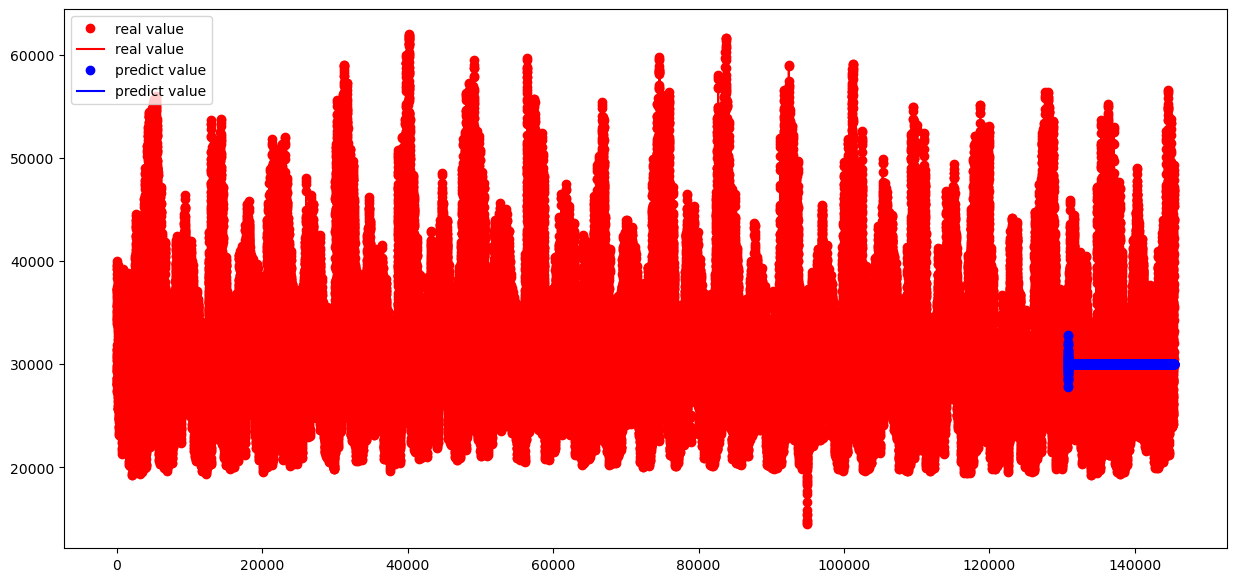

errors count 0
error MAE: 14.98 %
min error MAE: 14.98 %
max error MAE: 14.98 %
error RMSE: 19.76 %
min error RMSE: 19.76 %
max error RMSE: 19.76 %
____________________


In [13]:
MAE_error_value = []
RMS_error_value =[]
training_percent = 0.9

errors_count = 0
fine_count = 0

p = 2
d = 1
q = 4
sample = df[['PJME_MW']][:].values
x = np.r_[0:len(sample)]
end = int(training_percent * len(sample))

data_y_test = sample[end:]
data_y_train = sample[:end]
if np.count_nonzero(data_y_test) > 1:
    try:
        # arima = sm.tsa.arima.ARIMA(data_y_train, order=(p, d, q)).fit()
        arima = sm.tsa.statespace.SARIMAX(data_y_train, order=(p, d, q)).fit()
        predict = arima.predict(x[end], x[-1])
        
        plt.figure(figsize=(15,7))
        plt.plot(x, sample, 'or', label='real value')
        plt.plot(x, sample, 'red', label='real value')
        plt.plot(x[end:], predict, 'ob', label='predict value')
        plt.plot(x[end:], predict,  'blue', label='predict value')
        plt.legend(loc='upper left')
        plt.show()

        MAE_error_value.append(
            np.abs(metrics.mean_absolute_error(data_y_test, predict)) / abs(np.mean(data_y_test)))
        RMS_error_value.append(np.sqrt(metrics.mean_squared_error(data_y_test, predict)) / abs(np.mean(data_y_test)))
    except (ValueError, np.linalg.linalg.LinAlgError):
        errors_count = errors_count + 1
print ('errors count', errors_count)
fine_count = len(MAE_error_value)
MAE_error_value = np.array(MAE_error_value) * 100.0
# print('errors MAE', MAE_error_value)
print ('error MAE:', "%.2f" % np.mean(MAE_error_value), '%')
print('min error MAE:', "%.2f" % np.min(MAE_error_value), '%')
print('max error MAE:', "%.2f" % np.max(MAE_error_value), '%')
RMS_error_value = np.array(RMS_error_value) * 100.0
# print('errors RMSE', RMS_error_value)
print('error RMSE:', "%.2f" % np.mean(RMS_error_value), '%')
print('min error RMSE:', "%.2f" % np.min(RMS_error_value), '%')
print('max error RMSE:', "%.2f" % np.max(RMS_error_value), '%')
print ('_' * 20)

In [14]:
model=sm.tsa.arima.ARIMA(train['PJME_MW'],order=(2,1,4))
model_fit=model.fit()
model_fit.summary()
# arima = sm.tsa.arima.ARIMA(data_y_train, order=(p, d, q)).fit()

/usr/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJME_MW   No. Observations:               136606
Model:                 ARIMA(2, 1, 4)   Log Likelihood            -1079860.617
Date:                Mon, 29 Apr 2024   AIC                        2159735.235
Time:                        10:33:22   BIC                        2159804.009
Sample:                    01-01-2002   HQIC                       2159755.818
                         - 08-03-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6745      0.001   1241.977      0.000       1.672       1.677
ar.L2         -0.9329      0.001   -719.167      0.000      -0.935      -0.930
ma.L1         -0.5441      0.002   -248.678      0.000      -0.548      -0.540
ma.L2         -0.2815      0.002   -156.263      0.000      -0.285      -0.278
ma.L3          0.3703      0.003    132.495      0.000       0.365       0.376
ma.L4          0.3685      0.003    126.996      0.000       0.363       0.374
sigma2       4.29e+05   1118.187    383.673      0.000    4.27e+05    4.31e+05
===================================================================================
Ljung-Box (L1) (Q):                 119.10   Jarque-Bera (JB):            148738.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

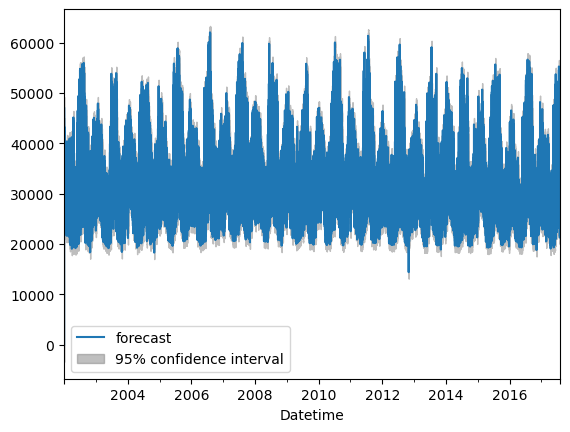

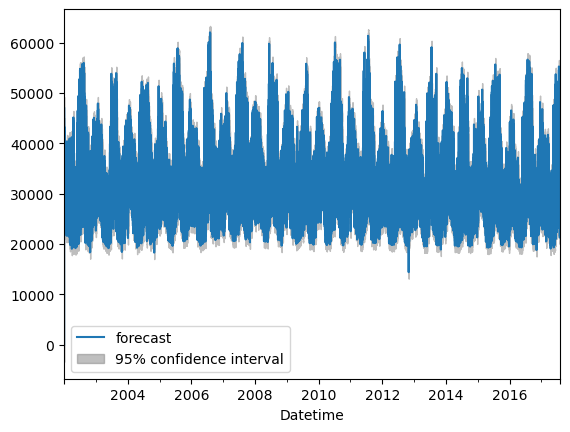

In [15]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model_fit)
# plt.show(figsize=(15, 5))